This following analysis code is a demonstration of generating false-positives (also known as p-hacking) using random data. We will be using an example dataset, brainsize.csv. We will be calculating correlation matrices with the random and collected data. To find the "optimal" distribution of random data yielding either significant (p<0.05) or non-significant (p>0.05) correlations, we will be iterating through a list of seeds which will vary the random sampling from a standard normal distribution.

Requirements are listed in ReadMe.md

We start off by importing the necessary libraries.

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

The following five functions will be used to conduct our analysis.

This function will load the dataset from a csv file, and return a pandas dataframe. The csv file is specified using its filepath.

In [21]:
def load_data(filepath):
	return pd.read_csv(filepath, sep=';')

This function will clean the dataframe from our example dataset. The column "Unnamed: 0" is removed, as the dataset already has its own indices. It replaces periods with NaNs, and converts Height and Weight object dtypes to float dtypes.

In [22]:
def clean_data(df):
	df.replace({'.': np.nan}, inplace=True)
	df = df.drop(columns='Unnamed: 0')
	df['Height'] = df['Height'].astype(float)
	df['Weight'] = df['Weight'].astype(float)
	return df

This function will add a column of random noise, from a standard normal distribution with a set seed, to the dataframe.

In [23]:
def add_noise(df, col_name, seed):
	len_rows = df.shape[0]
	np.random.seed(seed)
	partY = np.random.standard_normal(len_rows)
	df[col_name] = partY
	return df

The following first function returns the p-value for a pearson correlation. It is used in the second function, which returns a correlation matrix for the whole dataframe.

In [24]:
def pearsonr_pval(x,y):
	return pearsonr(x,y)[1]


def generate_corr(df, col_name):
	corr = df.corr(method=pearsonr_pval)[col_name]
	return corr

The following code loads the .csv dataset, cleans the data, and sets a maximum seed value for finding significant correlations.

In [25]:
brainsize_csv_filepath = "./brainsize.csv"
df = load_data(brainsize_csv_filepath)
df = clean_data(df)
seed_max = 1000000

This for loop will search seeds, up to the pre-set max, in order to find one that yields at least 5 significant correlations (p<0.05) between the random and collected data. The p-values and seed are printed.

In [26]:
for seed_i in range(seed_max):
    df = add_noise(df, 'partY', seed_i)
    corr = generate_corr(df, 'partY')
    sig_corr = corr.where(corr.abs() < 0.05).dropna()
    if sig_corr.shape[0] > 5:
        print('Correlations Successful, where p < 0.05:')
        print(corr)
        print('Iteration had size: ', sig_corr.shape[0], ' with seed: ', seed_i)
        break

Correlations Successful, where p < 0.05:
FSIQ         0.015062
VIQ          0.013803
PIQ          0.042275
Weight       0.014603
Height       0.023728
MRI_Count    0.001682
partY        1.000000
Name: partY, dtype: float64
Iteration had size:  6  with seed:  15210


This for loop will search seeds, up to the pre-set max, in order to find one that yields at least 6 non-significant correlations (p>0.05) between the random and collected data. The p-values and seed are printed.

In [27]:
for seed_j in range(seed_max):
    df2 = add_noise(df, 'partY2', seed_j)
    corr2 = generate_corr(df2, 'partY2')
    sig_corr2 = corr2.where(corr2.abs() >= 0.05).dropna()
    if sig_corr2.shape[0] > 6:
        print('Correlations Successful, where p > 0.05 across most:')
        print(corr2)
        print('Iteration had size: ', sig_corr2.shape[0], ' with seed: ', seed_j)
        break

Correlations Successful, where p > 0.05 across most:
FSIQ         0.948410
VIQ          0.855310
PIQ          0.563705
Weight       0.083650
Height       0.122112
MRI_Count    0.044080
partY        0.583169
partY2       1.000000
Name: partY2, dtype: float64
Iteration had size:  7  with seed:  1


This code will illustrate the correlation matrix as a heatmap. Notice how partY correlates with the rest of the dataset with values greater than -0.4, and how partY2 correlates with the rest of the dataset with values around 0.

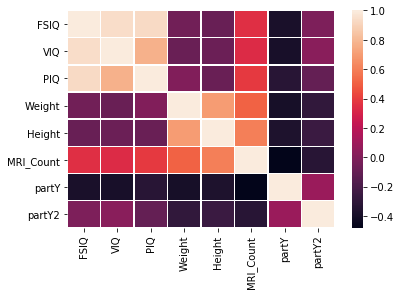

In [28]:
ax = sns.heatmap(df2.corr(), linewidth=0.5)
plt.show()